<a href="https://colab.research.google.com/github/selcancelikel/bitirmeprojesi/blob/main/cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lütfen log CSV dosyanı yükle:


Saving robust_50k_logs.csv to robust_50k_logs (3).csv
Epoch 1/5 | Train Loss: 0.1674 | Val Loss: 0.1200 | Train Acc: 0.7870 | Val Acc: 0.7756
Epoch 2/5 | Train Loss: 0.0950 | Val Loss: 0.1074 | Train Acc: 0.8364 | Val Acc: 0.9174
Epoch 3/5 | Train Loss: 0.0609 | Val Loss: 0.0391 | Train Acc: 0.9263 | Val Acc: 0.9769
Epoch 4/5 | Train Loss: 0.0178 | Val Loss: 0.0452 | Train Acc: 0.9856 | Val Acc: 0.9898
Epoch 5/5 | Train Loss: 0.0114 | Val Loss: 0.0133 | Train Acc: 0.9897 | Val Acc: 0.9956


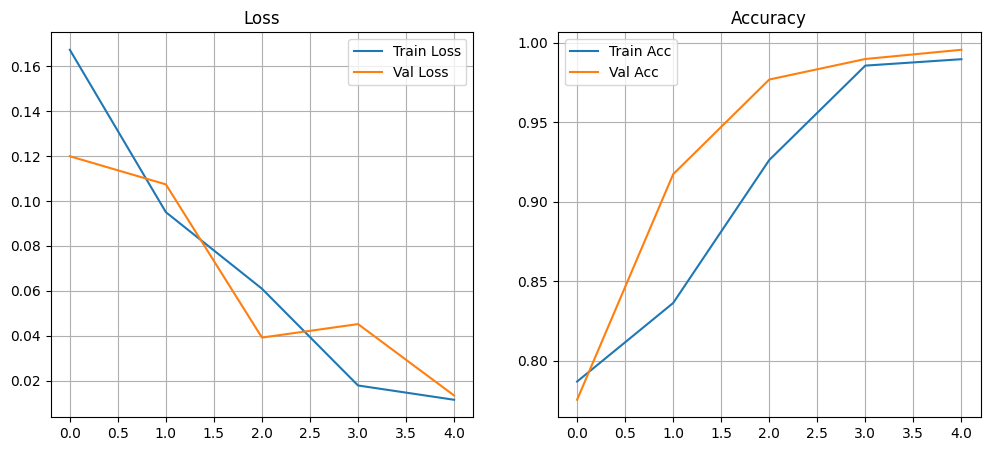

F1 Score: 0.997073300518824
ROC AUC: 0.9955778502619687


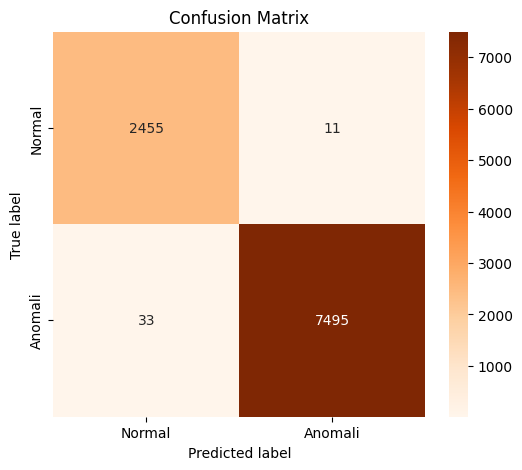

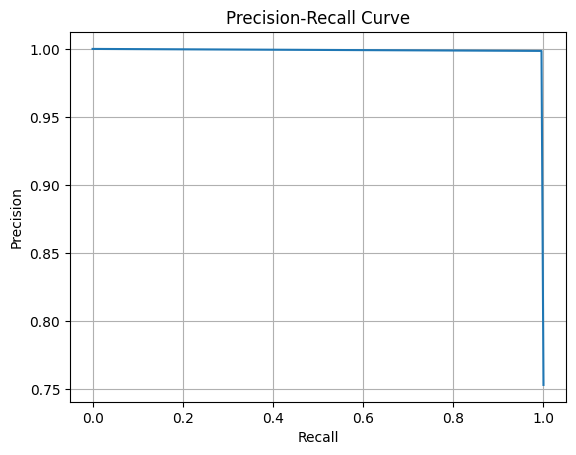

ValueError: x and y must have same first dimension, but have shapes (49970,) and (9994,)

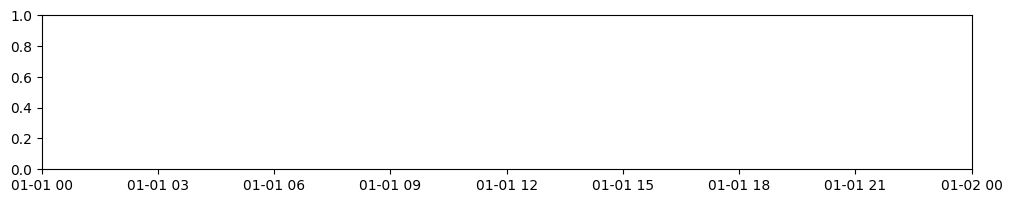

In [ ]:
# === GEREKLİ KÜTÜPHANELER ===
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
import datetime

# === DOSYA YÜKLEME ===
print("Lütfen log CSV dosyanı yükle:")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

# === GELİŞMİŞ VERİ ÖN İŞLEME ===
def preprocess_and_window_v2(df, window_size=30):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['is_night'] = df['hour'].apply(lambda h: 1 if h < 6 else 0)
    df['is_weekend'] = df['dayofweek'].apply(lambda d: 1 if d >= 5 else 0)
    df['time_diff'] = df['timestamp'].diff().dt.total_seconds().fillna(0)
    df['delta_size'] = df['file_size'].diff().fillna(0)
    df['file_extension'] = df['file_path'].apply(lambda x: x.split('.')[-1] if '.' in x else 'none')

    df['file_path_enc'] = LabelEncoder().fit_transform(df['file_path'])
    df['operation_enc'] = LabelEncoder().fit_transform(df['operation'])
    df['file_ext_enc'] = LabelEncoder().fit_transform(df['file_extension'])

    scaler = MinMaxScaler()
    df[['file_size_scaled', 'delta_size_scaled', 'time_diff_scaled']] = scaler.fit_transform(
        df[['file_size', 'delta_size', 'time_diff']]
    )

    features = [
        'file_path_enc', 'operation_enc', 'file_ext_enc',
        'file_size_scaled', 'delta_size_scaled', 'time_diff_scaled',
        'hour', 'dayofweek', 'is_night', 'is_weekend'
    ]

    X, y = [], []
    for i in range(len(df) - window_size):
        seq = df[features].iloc[i:i + window_size].values
        label = 1 if df['label'].iloc[i:i + window_size].sum() > 0 else 0
        X.append(seq)
        y.append(label)

    return np.array(X), np.array(y)

# === Dataset Sınıfı ===
class LogDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# === CNN+LSTM Modeli ===
class CNNLSTMAnomaly(nn.Module):
    def __init__(self, input_size, cnn_channels=32, lstm_hidden=128, num_layers=2, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, cnn_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(cnn_channels, lstm_hidden, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden * 2, 2)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out)

# === Eğitim & Değerlendirme ===
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            total_loss += loss.item() * yb.size(0)
            preds = outputs.argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    return total_loss / total, correct / total, all_preds, all_labels

def train_model(model, train_dl, val_dl, config, device):
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 5.0]).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)

    best_loss = float('inf')
    best_state = None
    no_improve = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    writer = SummaryWriter(log_dir=f"runs/anomaly_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}")

    for epoch in range(config['epochs']):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * yb.size(0)
            correct += (outputs.argmax(1) == yb).sum().item()
            total += yb.size(0)

        train_loss = total_loss / total
        train_acc = correct / total
        val_loss, val_acc, _, _ = evaluate(model, val_dl, criterion, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Val", val_loss, epoch)
        writer.add_scalar("Acc/Train", train_acc, epoch)
        writer.add_scalar("Acc/Val", val_acc, epoch)

        print(f"Epoch {epoch+1}/{config['epochs']} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= config['early_stopping']:
                print("⏹️ Early stopping.")
                break
        scheduler.step(val_loss)

    model.load_state_dict(best_state)
    writer.close()
    return model, history

# === METRİK VE GRAFİKLER ===
def plot_metrics(history):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend(); plt.title("Loss"); plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.legend(); plt.title("Accuracy"); plt.grid(True)
    plt.show()

def show_confusion(labels, preds):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Normal','Anomali'], yticklabels=['Normal','Anomali'])
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.show()

def show_pr_curve(labels, preds):
    precision, recall, _ = precision_recall_curve(labels, preds)
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.show()

def show_anomaly_timeline(df, preds, window_size):
    timeline = df['timestamp'][window_size:].reset_index(drop=True)
    plt.figure(figsize=(12,2))
    plt.plot(timeline, preds, label='Predicted')
    plt.plot(timeline, df['label'][window_size:].reset_index(drop=True), alpha=0.5, label='Actual')
    plt.legend()
    plt.title("Zaman Çizelgesinde Anomali Tahminleri")
    plt.xlabel("Zaman")
    plt.ylabel("Etiket")
    plt.show()

def anomaly_summary(labels, preds):
    cm = confusion_matrix(labels, preds)
    TP, FN = cm[1,1], cm[1,0]
    FP, TN = cm[0,1], cm[0,0]
    print(f"✔ TP: {TP}, ✔ TN: {TN}, ❌ FP: {FP}, ❌ FN: {FN}")

# === ANA AKIŞ ===
config = {
    'window_size': 30,
    'test_size': 0.2,
    'batch_size': 128,
    'lr': 0.001,
    'epochs': 5,
    'early_stopping': 5,
}

X, y = preprocess_and_window_v2(df, config['window_size'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=config['test_size'], shuffle=False)

train_dl = DataLoader(LogDataset(X_train, y_train), batch_size=config['batch_size'], shuffle=True)
val_dl = DataLoader(LogDataset(X_val, y_val), batch_size=config['batch_size'], shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNLSTMAnomaly(input_size=X.shape[2]).to(device)

model, history = train_model(model, train_dl, val_dl, config, device)
plot_metrics(history)

val_loss, val_acc, preds, labels = evaluate(model, val_dl, nn.CrossEntropyLoss(), device)
print("F1 Score:", f1_score(labels, preds))
print("ROC AUC:", roc_auc_score(labels, preds))

# === GÖRSEL ANALİZLER ===
show_confusion(labels, preds)
show_pr_curve(labels, preds)
show_anomaly_timeline(df, preds, config['window_size'])
anomaly_summary(labels, preds)
